### Example getting T and EM from GOES/XRS15 data

At the moment just for GOES15 and using CHIANTI with coronal abundances, using python port of sswidl [goes_tem_calc.pro](https://hesperia.gsfc.nasa.gov/ssw/gen/idl/synoptic/goes/goes_tem_calc.pro).

* 24-10-2021 IGH
* 25-10-2021 IGH  -  Updated to return newer CHIANTI v9 responses, and option of abundance and sat
* 04-11-2021 IGH  -  Improved order and documentation
* 24-05-2022 IGH  -  Updated to use newer CHIANTI v10 and fixed short responses
* 02-08-2022 IGH  -  Updated to turn result into pandas df, and calc mean T, EM during onset
---

In [1]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import goesxrs_temp as gtem

from sunpy import timeseries as ts
from sunpy.net import attrs as a

from pandas import DataFrame

# Just setup plot fonts
plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

In [2]:
# Let's get the T responses:
resps, resptmk = gtem.get_resps(sat=15)

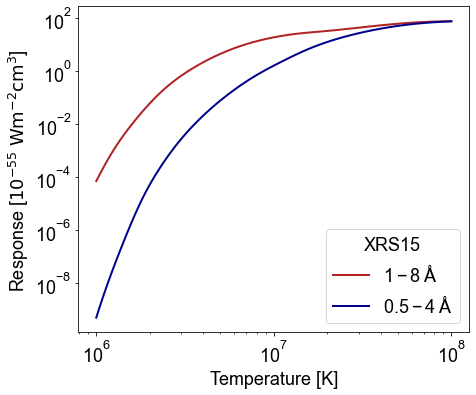

In [3]:
# Plot them to see what they look like:
fig,ax = plt.subplots(figsize=(7, 6))
plt.plot(1e6*resptmk,resps[:,0],marker=None,color='firebrick',lw=2,label='$1-8\;\AA$')
plt.plot(1e6*resptmk,resps[:,1],marker=None,color='darkblue',lw=2,label='$0.5-4\;\AA$')

ax.set_ylabel("Response [$\mathrm{10^{-55}\;Wm^{-2}cm^{3}}$]")
ax.set_xlabel("Temperature [K]")
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(title='XRS15')
plt.show()

If we assume the emission is isothermal then the observed fluxes ($F$ in $[W\;m^{-2}]$) is related to the emission measure ($EM_0=n^2V$ in $[cm^{-3}]$) and the response function ($TR$ in $[W\;m^{-2}\;cm^{3}]$) at the isothermal temperature ($T_0$ in $[K]$) via:

$F_{1-8}= EM_0 \times TR_{1-8}(T_0)\quad$ and $\quad F_{0.5-4}= EM_0 \times TR_{0.5-4}(T_0)$.

Which then gives:

$\dfrac{F_{0.5-4}}{F_{1-8}}= \dfrac{TR_{0.5-4}(T_0)}{TR_{1-8}(T_0)}$

So the ratio of the observed fluxes in the two channels will equal of the two temperature responses at the isothermal temperature.

Hence you can find the isothermal temperature by identifying the temperature which gives the same ratio of the responses that matches the ratio of the observed fluxes.

In [4]:
# Could work out the TR ratio from above cells, but also have a function for that
resprat, resptmk = gtem.get_resprat(sat=15)

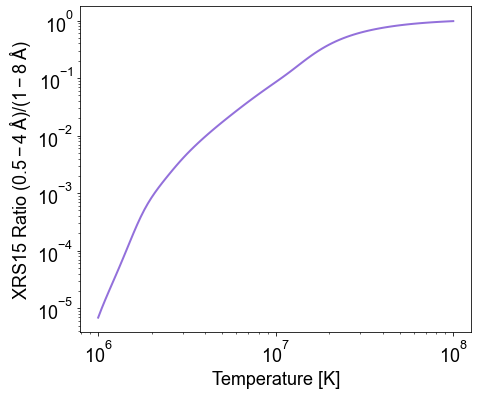

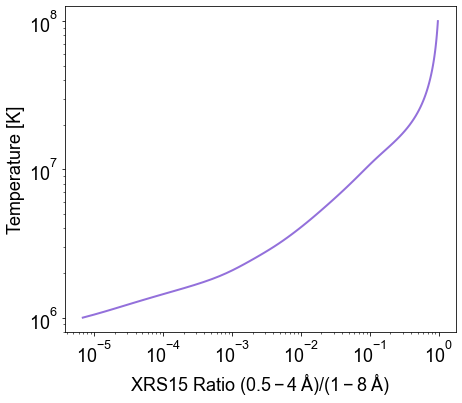

In [5]:
# Plot it to see what it is like:
fig,ax = plt.subplots(figsize=(7, 6))
plt.plot(1e6*resptmk,resprat,marker=None,color='mediumpurple',lw=2)
ax.set_ylabel("XRS15 Ratio $(0.5-4\;\AA)$/$(1-8\;\AA)$")
ax.set_xlabel("Temperature [K]")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

# Might be more useful to swap the axes about, since know the ratio from the data and want the corresponding T
fig,ax = plt.subplots(figsize=(7, 6))
plt.plot(resprat,1e6*resptmk,marker=None,color='mediumpurple',lw=2)
ax.set_xlabel("XRS15 Ratio $(0.5-4\;\AA)$/$(1-8\;\AA)$")
ax.set_ylabel("Temperature [K]")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()


In [6]:
# # Some testing that it works for single obs
tmk, em=gtem.get_tem(1e-8/0.04,1e-8)
print(tmk,em)

# # works for array of values including bad ones
fl=[1e-8/0.04,2e-8/0.04,-1,1e-9]
fs=[1e-8,1e-8,1e-8,1e-8]
tmks,ems=gtem.get_tem(fl,fs)
print(tmks)
print(ems)

# Note that for values outside the response ratio range above, a limiting value is given instead for the T
# and a limiting or erroneous value will be given for the EM.

7.103514397448267 2.3319175785780735e+47
[  7.1035144    5.31688631   1.         100.        ]
[2.33191758e+47 9.38513471e+47 0.00000000e+00 1.29327272e+44]


---
##### Now getting T, EM from XRS data
Using a real flare as an example

In [7]:
#  OK lets now try with real data
# Assumes have downloaded data, see https://github.com/ianan/xrs_example/blob/main/xrs15_example.ipynb
# Load data into timeseries
outdir='/Users/iain/sunpy/data/'
fg15=glob.glob(outdir+'*g15*20101105*.nc')
g15 = ts.TimeSeries(fg15, concatenate=True)
# Then truncate to time range interested in
trange=a.Time("2010-11-05 12:00","2010-11-05 17:00")
tg15=g15.truncate(trange.start.iso,trange.end.iso)
# Extract out the time index and data channels
tg_tims=tg15.index
tg_x05=tg15.quantity("xrsa").value
tg_x18=tg15.quantity("xrsb").value

In [8]:
# Also need to work out an average background level in each GOES channel
# This is to subtract out the rest of the Sun from the flare 
# (which shouldn't be a big effect during the peak of the flare)
tbck=a.Time("2010-11-05 13:06:19","2010-11-05 13:07:30")
tbckg15=g15.truncate(tbck.start.iso,tbck.end.iso)
# Work out mean for each channel
# Need to be careful that no 0, negs or NaNs in there.....
bck05=np.mean(tbckg15.quantity("xrsa").value)
bck18=np.mean(tbckg15.quantity("xrsb").value)
print(bck05,bck18)

1.0091633e-08 5.327791e-07


In [9]:
# Work out values using original, no backsub
tmk, em=gtem.get_tem(tg_x18,tg_x05)
# And with the background subtraction
tmk_bs,em_bs=gtem.get_tem(tg_x18-bck18,tg_x05-bck05)

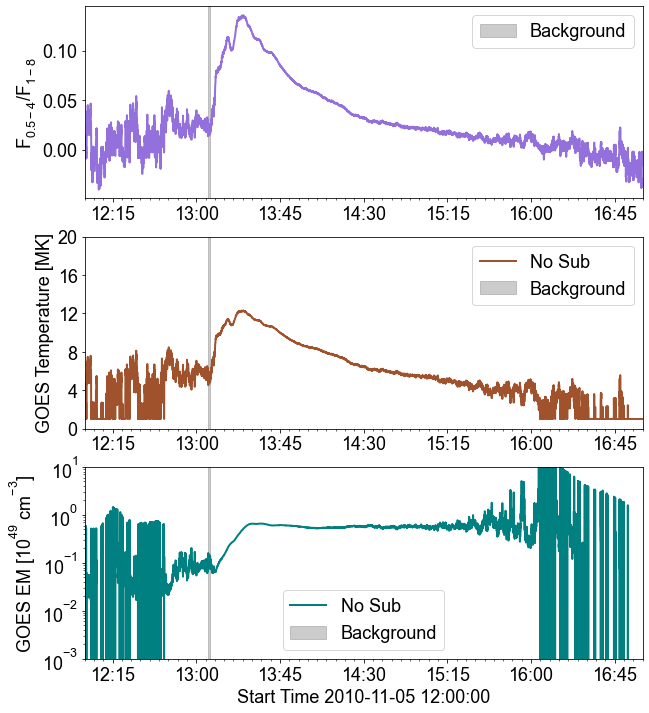

In [10]:
# Plot just the non-background subtracted for whole time range
# Showing the ratio of (0.5-4)/(1-8), the T and EM

fig= plt.figure(figsize=(10, 12))

ax0 = fig.add_subplot(3, 1, 1)
plt.plot(tg_tims,tg_x05/tg_x18,marker=None,color='mediumpurple',lw=2)
ax0.set_ylabel("$F_{0.5-4}/F_{1-8}$")
ax0.set_xlabel(" ")
ax0.set_xlim([trange.start.datetime,trange.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=45)
minorx= matplotlib.dates.MinuteLocator(interval=5)
ax0.xaxis.set_major_locator(majorx)
ax0.xaxis.set_minor_locator(minorx)
ax0.xaxis.set_major_formatter(myFmt)
ax0.axvspan(tbck.start.datetime,tbck.end.datetime,color='grey',alpha=0.4, label='Background')
plt.legend()

ax1 = fig.add_subplot(3, 1, 2)
plt.plot(tg_tims,tmk,marker=None,color='sienna',lw=2,label='No Sub')
ax1.set_ylabel("GOES Temperature [MK]")
ax1.set_xlabel(" ")
ax1.set_ylim([0,20])
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlim([trange.start.datetime,trange.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=45)
minorx= matplotlib.dates.MinuteLocator(interval=5)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
ax1.axvspan(tbck.start.datetime,tbck.end.datetime,color='grey',alpha=0.4, label='Background')
plt.legend()

ax2 = fig.add_subplot(3, 1, 3)
plt.plot(tg_tims,em*1e-49,marker=None,color='teal',lw=2,label='No Sub')
ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_xlabel("Start Time "+trange.start.iso[:-4])
ax2.set_ylim([1e-3,1e1])
ax2.set_yscale("log")
ax2.set_xlim([trange.start.datetime,trange.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=45)
minorx= matplotlib.dates.MinuteLocator(interval=5)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
ax2.axvspan(tbck.start.datetime,tbck.end.datetime,color='grey',alpha=0.4, label='Background')
plt.legend()

plt.show()

# Can see get limiting/wrong T,EM at times the ratio is <1e-5

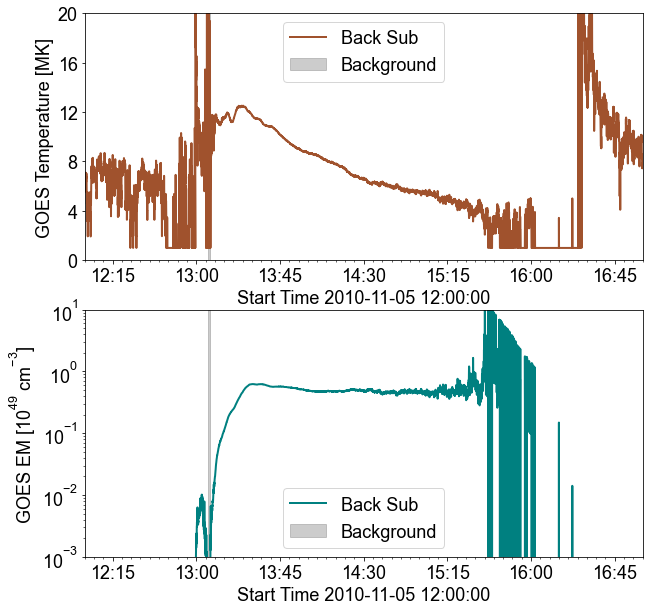

In [11]:
# Plot background subtracted for whole time range
fig= plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2, 1, 1)
plt.plot(tg_tims,tmk_bs,marker=None,color='sienna',lw=2,label='Back Sub')
ax1.set_ylabel("GOES Temperature [MK]")
ax1.set_xlabel("Start Time "+trange.start.iso[:-4])
ax1.set_ylim([0,20])
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlim([trange.start.datetime,trange.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=45)
minorx= matplotlib.dates.MinuteLocator(interval=5)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
ax1.axvspan(tbck.start.datetime,tbck.end.datetime,color='grey',alpha=0.4, label='Background')
plt.legend()

ax2 = fig.add_subplot(2, 1, 2)
plt.plot(tg_tims,em_bs*1e-49,marker=None,color='teal',lw=2,label='Back Sub')
ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_xlabel("Start Time "+trange.start.iso[:-4])
ax2.set_ylim([1e-3,1e1])
ax2.set_yscale("log")
ax2.set_xlim([trange.start.datetime,trange.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=45)
minorx= matplotlib.dates.MinuteLocator(interval=5)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
ax2.axvspan(tbck.start.datetime,tbck.end.datetime,color='grey',alpha=0.4, label='Background')
plt.legend()
plt.show()

# So obvioulsy T,EM bad for times not during the flare, with pre-flare background subtracted

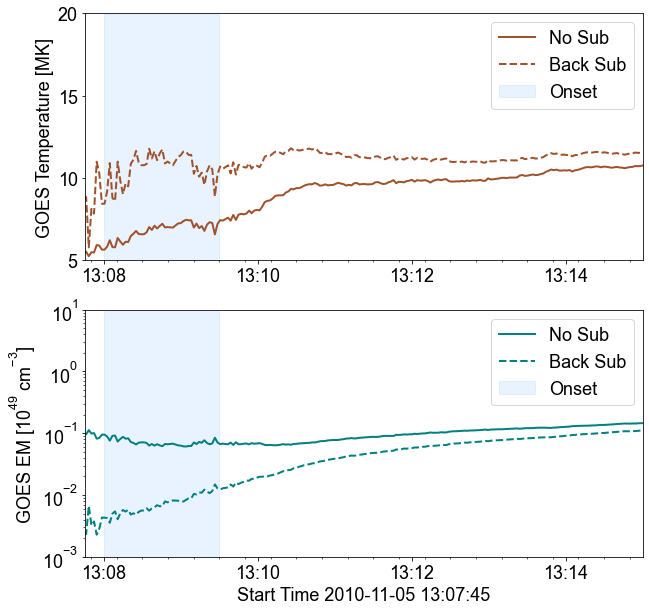

In [12]:
# Just plot range close to Fig 1 in Hudson et al. 2021 paper so can consider 
tr2=a.Time("2010-11-05 13:07:45","2010-11-05 13:15:00")
tho=a.Time("2010-11-05 13:08:00","2010-11-05 13:09:30")

fig= plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2, 1, 1)
plt.plot(tg_tims,tmk,marker=None,color='sienna',lw=2,label='No Sub')
plt.plot(tg_tims,tmk_bs,marker=None,color='sienna',lw=2,ls='--',label='Back Sub')
ax1.set_ylabel("GOES Temperature [MK]")
# ax1.set_xlabel("Start Time "+tr2.start.iso[:-4])
ax1.set_ylim([5,20])
ax1.yaxis.set_major_locator(plt.MaxNLocator(3))
ax1.set_xlim([tr2.start.datetime,tr2.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=20)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
ax1.axvspan(tho.start.datetime,tho.end.datetime,color='dodgerblue',alpha=0.1, label='Onset')
plt.legend()

ax2 = fig.add_subplot(2, 1, 2)
plt.plot(tg_tims,em*1e-49,marker=None,color='teal',lw=2,label='No Sub')
plt.plot(tg_tims,em_bs*1e-49,marker=None,color='teal',lw=2,ls='--',label='Back Sub')

ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_xlabel("Start Time "+tr2.start.iso[:-4])
ax2.set_ylim([1e-3,1e1])
ax2.set_yscale("log")
ax2.set_xlim([tr2.start.datetime,tr2.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=20)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
ax2.axvspan(tho.start.datetime,tho.end.datetime,color='dodgerblue',alpha=0.1, label='Onset')
plt.legend()
plt.show()


In [13]:
#  What is the mean T during the onset time?
#  Various ways of working this out but here will make a pandas dataframe of time vs tmk,em and then truncate to onset time
tem_df= DataFrame(data={'tmk':tmk_bs,'em49':em_bs}, index=tg_tims)

# truncate to just the hot onset time
tem_df_ho=tem_df.truncate(tho.start.datetime,tho.end.datetime)

# # Check new dataframe just contains the hot onset time 
# tem_df_ho['tmk'].plot()
# plt.show()
# tem_df_ho['em49'].plot()
# plt.show()

# Work out mean during onset time
tmk_mnho=np.mean(tem_df_ho['tmk'].values)
em_mnho=np.mean(tem_df_ho['em49'].values)
print('Mean T during onset: {0:.2f} MK'.format(tmk_mnho))
print('Mean EM during onset: {0:.2e} MK'.format(em_mnho))

Mean T during onset: 10.58 MK
Mean EM during onset: 7.49e+46 MK


In [14]:
# Above T similar to Hudson et al. 2021 paper but EM slightly higher
# Difference due to scalings no longer in the GOES data
# 
# Paper used the responses that had the unneeded extra short channel scaling factor, i.e.
# https://hesperia.gsfc.nasa.gov/goes/goes.html#Temperature/Emission%20Measure
# 
# And paper used the older GOES fluxes scaled in both channels (different scaling to above T response issue), 
# so in the paper this was an M1.0 flare, with no background subtraction but now it is ~M1.5 
# (max of 1-8A channel from new unscaled data)
print("Max 1-8 Flux: {0:.3e}".format(tg_x18.max()))
print("Max 1-8 Flux x0.7: {0:.3e}".format(0.7*tg_x18.max()))

Max 1-8 Flux: 1.487e-05
Max 1-8 Flux x0.7: 1.041e-05
